In [3]:
!git clone https://rilianx@github.com/rilianx/CPMP-ML.git

Cloning into 'CPMP-ML'...
remote: Enumerating objects: 1827, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 1827 (delta 101), reused 230 (delta 89), pack-reused 1581
Receiving objects: 100% (1827/1827), 6.69 MiB | 5.91 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [4]:
%cd CPMP-ML

/content/CPMP-ML


##Librerias Necesarias

In [103]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Input, Add, Dense, Layer, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D, InputLayer, Flatten
from keras.models import Model, load_model
from keras.utils import to_categorical
import cpmp_ml
import numpy as np
from cpmp_ml import generate_random_layout, generate_data, get_move
import random
import tensorflow as tf
from copy import deepcopy
import time

# Funciones necesarias

## Algoritmo Greedy y funciones para generación de datos

In [6]:
def is_valid_BG_move(layout, s_o, s_d):
    if (s_o != s_d  and len(layout.stacks[s_o]) > 0
    and  len(layout.stacks[s_d]) < layout.H
    and layout.is_sorted_stack(s_o)==False
    and layout.is_sorted_stack(s_d)==True
    and layout.gvalue(s_o) <= layout.gvalue(s_d)):
      return True

    else: return False

In [7]:
def select_bg_move(layout):
  bg_move = None
  S=len(layout.stacks)
  min_diff = 100
  for s_o in range(S):
     for s_d in range(S):
       if is_valid_BG_move(layout, s_o, s_d):
          diff = layout.gvalue(s_d) - layout.gvalue(s_o)
          if min_diff > diff:
            min_diff = diff
            bg_move = (s_o,s_d)
  return bg_move

In [8]:
def greedy(layout, basic=True):
    moves = []
    steps = 0
    while layout.unsorted_stacks>0:
        bg_move=select_bg_move(layout)
        if bg_move is not None:
            moves.append(bg_move)
            layout.move(bg_move)
        else:
            return -1, None # no lo resuelve
        steps +=1

    if layout.unsorted_stacks==0:
        return steps, moves
    return -1, None

In [9]:
def unlist(data,labels1, labels2, state, source, destination):
  n = len(source)
  for i in range(n):
    data.append(state[i])
    labels1.append(source[i])
    labels2.append(destination[i])

In [10]:
def get_ann_state(layout):
  S=len(layout.stacks)
  #matriz de stacks
  b = 2. * np.ones([S,layout.H + 1])
  for i,j in enumerate(layout.stacks):
     b[i][layout.H-len(j) + 1:] = [k/layout.total_elements for k in j]
     b[i][0] = layout.is_sorted_stack(i)
  b.shape=(S,(layout.H + 1))
  return b

#overriding the function in the module
cpmp_ml.get_ann_state = get_ann_state

In [11]:
def convert_label(score):
    list_score = []

    for i in score:
        list_score.append(i)

    return np.array(list_score)

In [12]:
def generate_steps_of_a_state(layout):
    states = [] # estados antes de movimiento
    source_tags = [] # etiquetas origen
    destination_tags = []  # etiquetas destino

    aux = deepcopy(layout)  # creación de copia de objeto

    steps, moves = greedy(aux)
    if steps == -1:
      return None, None, None

    for i in range(steps):
        states.append(get_ann_state(layout)) # antes del movimiento
        source_tags.append(convert_label(to_categorical(moves[i][0],len(layout.stacks))))
        destination_tags.append(convert_label(to_categorical(moves[i][1],len(layout.stacks))))
        layout.move(moves[i])
        aux = deepcopy(layout)

    return states, source_tags, destination_tags

In [91]:
def create_different_states(S, H, max_priority_container, n):
  data_state = []
  labels_source = []
  labels_destination = []
  iter = 0
  while iter < n:
    layout = generate_random_layout(S,H,max_priority_container)
    state, source, destination = generate_steps_of_a_state(layout)
    if state == None and source == None and destination == None: continue
    unlist(data_state,labels_source,labels_destination,state,source,destination)
    iter+=1

  return np.stack(data_state), np.stack(labels_source), np.stack(labels_destination)

## Funciones para entrenamiento y predicciones

In [16]:
def compare(predict, y_test):
    aciertos = 0
    size = len(predict)

    for i in range(size):
        max_1 = np.argmax(predict[i])
        max_2 = np.argmax(y_test[i])

        if max_1 == max_2:
            aciertos += 1

    return aciertos / size

In [100]:
def concatenate_state_with_output(states, outputs):
    tuple_data = zip(states, outputs)

    for state, output in tuple_data:
        i = 0
        for stacks in state:
            stacks.append(output[i])
            i += 1

In [18]:
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

## Funciones para cargar y guardar data

In [185]:
def save_data(data, labels_1, labels_2, name):
    size_stack = len(data[0])
    size_height = len(data[0][0])
    total_data = len(data)
    tuple_data = zip(data, labels_1, labels_2)

    with open(name + '.csv', 'w') as archivo:
        archivo.write('Total data: ' + str(total_data) + '\n')
        archivo.write('Stacks:' + str(size_stack) + ',Height:' + str(size_height) + '\n')
        archivo.write('\n')

        for matrix, label_1, label_2 in tuple_data:
            lista_stack = matrix.flatten()
            archivo.write('matrix:' + str(lista_stack.tolist())[1:-1] + '\n')
            archivo.write('label_1:' + str(label_1.tolist())[1:-1] + '\n')
            archivo.write('label_2:' + str(label_2.tolist())[1:-1] + '\n')
            archivo.write('\n')

        archivo.close()

In [186]:
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

# Modelo de atención y clasificador de stacks

In [19]:
# Capa de normalización de datos
def normalization_layer(input, attention):
    layer = Add()([input,attention])
    layer = LayerNormalization(epsilon=1e-6)(layer)
    return layer

In [20]:
# Capa de feed-fordward, en el fondo es la parte entrenable
# que ayuda al modelo a darle caracteristicas a las entradas
def feed_forward_layer(input, num_neuron):
    # capa de feed para que el modelo pueda aprender
    layer = Dense(num_neuron,activation='sigmoid')(input)
    layer = Dense(num_neuron)(layer)
    return layer

In [21]:
# capa de atencion, al principio se probará con un cabezal,
# que corresponde calcular un scaled-dot-product-attention
def attention_layer(heads, d_model, reshape):
    attention = MultiHeadAttention(num_heads=heads, key_dim=d_model)(reshape,reshape)
    return attention

In [99]:
# Creacion de modelo de clasificación binaria con softmax
def stack_attention(heads, d_model, reshape, input):
    # por si se debe modificar la dimensión
    attention = attention_layer(heads,d_model,reshape)
    normalization = normalization_layer(input, attention)
    feed = feed_forward_layer(normalization, d_model)

    return feed

In [98]:
def create_model(heads, S, H , optimizer):
    input = Input(shape= (S, H+1))

    reshape = stack_attention(heads, H + 1, input, input)
    reshape = stack_attention(heads, H + 1, reshape, input)

    reshape = Flatten()(reshape)
    hidden1 = Dense(H*6, activation='sigmoid')(reshape)
    dropout_1 = Dropout(0.5)(hidden1)
    hidden2 = Dense(H*6, activation='sigmoid')(dropout_1)
    output = Dense(S,activation='softmax')(hidden2)

    model = Model(inputs=input,outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['mae', 'mse', 'accuracy'])

    return model

# Diagrama del modelo

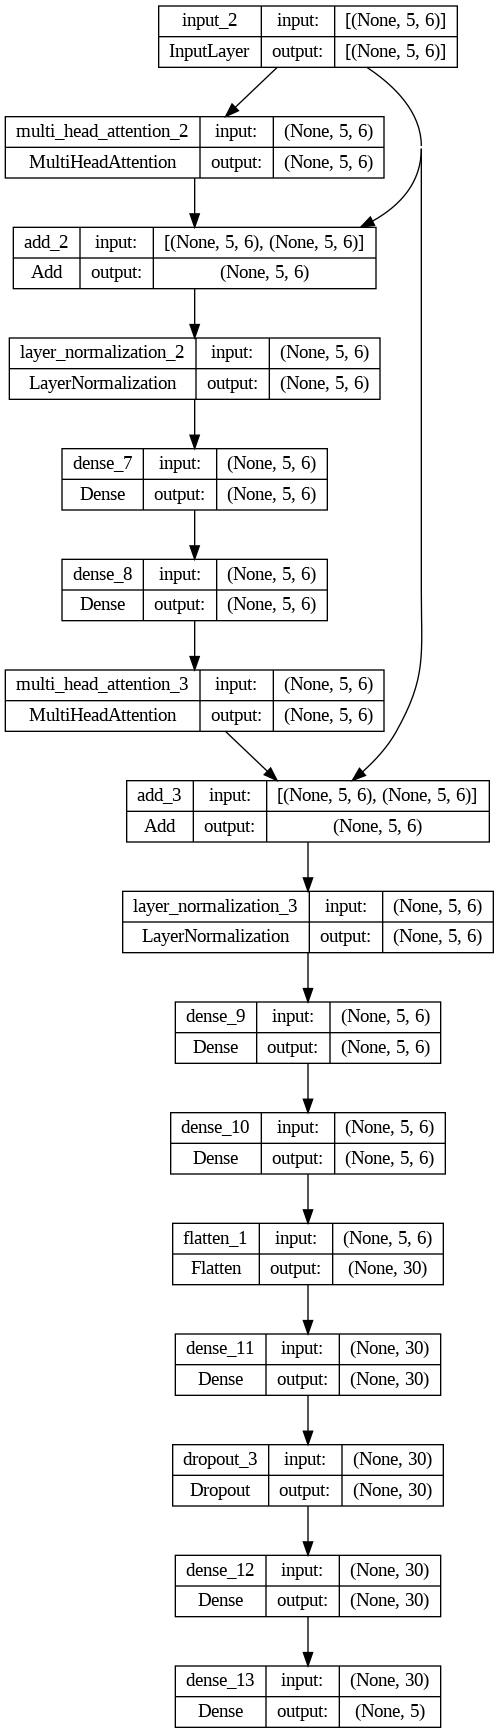

In [45]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin = create_model(heads= 5, S= 5, H= 5, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin,show_shapes=True)

# Generador de data

In [47]:
# Cantidad de stacks
S = 5#@param {type:'slider',min:1,max:1000,steps:1}

# Altura de la bahía
H = 5#@param {type:'slider',min:1,max:1000,steps:1}

# Número máximo de prioridad
MPC = 15 #@param {type:'slider',min:1,max:1000,steps:1}

# Cantida casos de entrenamiento
N = 41550 #@param {type:'slider',min:1,max:100000,steps:1}

X_train, y_train_1, y_train_2 = create_different_states(S, H, MPC, N)

In [106]:
# Cantidad de stacks
S2 = 5 #@param {type:'slider',min:1,max:100,steps:1}

# Altura de la bahía
H2 = 5 #@param {type:'slider',min:1,max:100,steps:1}

# Número máximo de prioridad
MPC2 = 15 #@param {type:'slider',min:1,max:100,steps:1}

# Cantida casos de prueba
N2 = 1 #@param {type:'slider',min:1,max:10000,steps:1}

X_test, y_test_1, y_test_2 = create_different_states(S2, H2, MPC2, N2)

# Entrenamiento y pruebas

In [51]:
model_cpmp_origin.fit(X_train, y_train_1, epochs= 20, batch_size= 32)

Epoch 1/20
7780/7780 [==============================] - 67s 9ms/step - loss: 0.4365 - mae: 0.1082 - mse: 0.0534 - accuracy: 0.7965
Epoch 2/20
7780/7780 [==============================] - 66s 8ms/step - loss: 0.3991 - mae: 0.0991 - mse: 0.0490 - accuracy: 0.8158
Epoch 3/20
7780/7780 [==============================] - 66s 9ms/step - loss: 0.3611 - mae: 0.0895 - mse: 0.0443 - accuracy: 0.8360
Epoch 4/20
7780/7780 [==============================] - 67s 9ms/step - loss: 0.3369 - mae: 0.0834 - mse: 0.0413 - accuracy: 0.8473
Epoch 5/20
7780/7780 [==============================] - 66s 8ms/step - loss: 0.3184 - mae: 0.0782 - mse: 0.0387 - accuracy: 0.8596
Epoch 6/20
7780/7780 [==============================] - 66s 8ms/step - loss: 0.2991 - mae: 0.0735 - mse: 0.0363 - accuracy: 0.8689
Epoch 7/20
7780/7780 [==============================] - 66s 8ms/step - loss: 0.2792 - mae: 0.0683 - mse: 0.0338 - accuracy: 0.8800
Epoch 8/20
7780/7780 [==============================] - 66s 8ms/step - loss: 0.2549

In [95]:
predict = model_cpmp_origin.predict(X_test)

840/840 [==============================] - 3s 4ms/step


In [97]:
result = compare(predict, y_test_1)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 96.8%


In [90]:
model_cpmp_origin.save("model_cpmp_origin_5x5.h5")